# Random Forest

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_contour, plot_slice
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.inspection import permutation_importance

from model_utils import calc_gini_coef, plot_pr_curve, plot_roc_curve

In [39]:
from model_utils import split_dataset, split_dataset_v2

# FEATURES_PATH = '../data/features_selected/features_v6_rfe_lgb_v4.csv'
FEATURES_PATH = '../prod_test/features_v1/features_v1_boruta_md5_perc100_iter150.csv'

X_train, X_valid, X_test, y_train, y_valid, y_test = split_dataset_v2(FEATURES_PATH, valid_size=0.2)

## Hyperparameter tuning

### Random Search

In [9]:
param_dist = {
    'n_estimators': [300, 500, 800],
    'max_depth': [4, 6, 8, None],
    'min_samples_leaf': [20, 50, 100, 200],
    'min_samples_split': [50, 100, 200],
    'max_features': [0.3, 0.4, 0.5, 'sqrt'],
    'bootstrap': [True]
}

In [10]:
model_base = RandomForestClassifier(
    class_weight='balanced',
    n_jobs=1,
    random_state=42
)

In [12]:
random_search = RandomizedSearchCV(
    model_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=6,
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'bootstrap': [True], 'max_depth': [4, 6, ...], 'max_features': [0.3, 0.4, ...], 'min_samples_leaf': [20, 50, ...], ...}"
,n_iter,30
,scoring,'roc_auc'
,n_jobs,6
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [20]:
random_search.best_params_

{'n_estimators': 800,
 'min_samples_split': 50,
 'min_samples_leaf': 20,
 'max_features': 0.4,
 'max_depth': None,
 'bootstrap': True}

### Bayesian Optimization

In [85]:
ALPHA = 0.75  # used for penalizing gap between train and validation score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 25, 200),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 75, 250),
        'max_features': trial.suggest_float('max_features', 0.4, 0.9),
        'bootstrap': True,
        'class_weight': 'balanced',
        'n_jobs': 6,
        'random_state': 42
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestClassifier(**params)
        model.fit(X_tr, y_tr)

        y_tr_pred_proba = model.predict_proba(X_tr)[:, 1]
        y_va_pred_proba = model.predict_proba(X_va)[:, 1]

        tr_gini = calc_gini_coef(y_tr, y_tr_pred_proba)
        va_gini = calc_gini_coef(y_va, y_va_pred_proba)

        score = va_gini - ALPHA * (tr_gini - va_gini)
        scores.append(score)

    return np.mean(scores)


In [86]:
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=20)

[I 2026-01-23 14:27:30,222] A new study created in memory with name: no-name-27694514-2e39-48cc-a244-0aaef5804ab6
[I 2026-01-23 14:27:59,300] Trial 0 finished with value: 0.48979528151641666 and parameters: {'n_estimators': 350, 'max_depth': 15, 'min_samples_split': 233, 'min_samples_leaf': 98, 'max_features': 0.37800932022121825}. Best is trial 0 with value: 0.48979528151641666.
[I 2026-01-23 14:28:19,408] Trial 1 finished with value: 0.4611446048808402 and parameters: {'n_estimators': 262, 'max_depth': 3, 'min_samples_split': 267, 'min_samples_leaf': 98, 'max_features': 0.6540362888980227}. Best is trial 0 with value: 0.48979528151641666.
[I 2026-01-23 14:28:50,262] Trial 2 finished with value: 0.48503300589609194 and parameters: {'n_estimators': 208, 'max_depth': 15, 'min_samples_split': 258, 'min_samples_leaf': 47, 'max_features': 0.3909124836035503}. Best is trial 0 with value: 0.48979528151641666.
[I 2026-01-23 14:29:18,494] Trial 3 finished with value: 0.49295093888461067 and pa

KeyboardInterrupt: 

In [87]:
print('Best score:', study.best_value)
print('Best params:', study.best_params)

Best score: 0.49844981190560744
Best params: {'n_estimators': 502, 'max_depth': 6, 'min_samples_split': 89, 'min_samples_leaf': 117, 'max_features': 0.5502528513622331}


In [98]:
plot_optimization_history(study)

In [99]:
plot_parallel_coordinate(study)

In [100]:
plot_slice(study)

In [101]:
plot_param_importances(study)

## Model training and evaluation

In [24]:
# Random search
model = random_search.best_estimator_

In [88]:
# Bayesian optimization
model = RandomForestClassifier(
    **study.best_params,
    bootstrap=True,
    class_weight='balanced',
    n_jobs=6,
    random_state=42,
)

In [3]:
# model = RandomForestClassifier(
#     n_estimators=600,
#     max_depth=6,
#     min_samples_leaf=50,
#     min_samples_split=100,
#     max_features=0.4,
#     class_weight='balanced',
#     n_jobs=6,
#     random_state=42,
# )

In [5]:
# Bayesian optimization hardcoded
model = RandomForestClassifier(
    n_estimators=502,
    max_depth=6,
    min_samples_leaf=117,
    min_samples_split=89,
    max_features=0.5502528513622331,
    class_weight='balanced',
    n_jobs=6,
    random_state=42,
)

In [31]:
model.fit(X_train, y_train)

,n_estimators,502
,criterion,'gini'
,max_depth,6
,min_samples_split,89
,min_samples_leaf,117
,min_weight_fraction_leaf,0.0
,max_features,0.5502528513622331
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [36]:
# y_true = y_train
# y_pred_proba = model.predict_proba(X_train)[:, 1]
# y_true = y_valid
# y_pred_proba = model.predict_proba(X_valid)[:, 1]
y_true = y_test
y_pred_proba = model.predict_proba(X_test)[:, 1]

Gini Coefficient:  0.5429572698995688


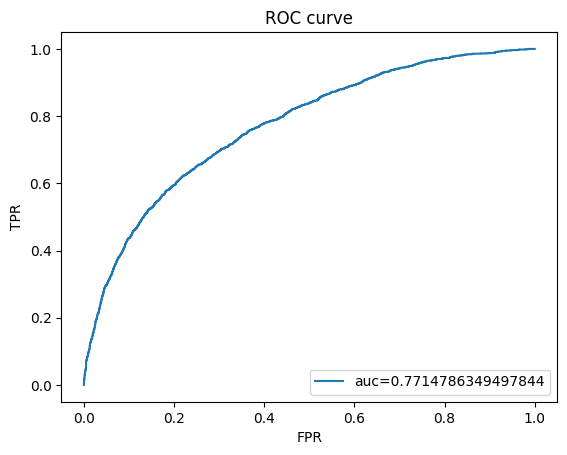

In [37]:
gini_coef = calc_gini_coef(y_true, y_pred_proba)
print('Gini Coefficient: ', gini_coef)

plot_roc_curve(y_true, y_pred_proba)

## Feature importance

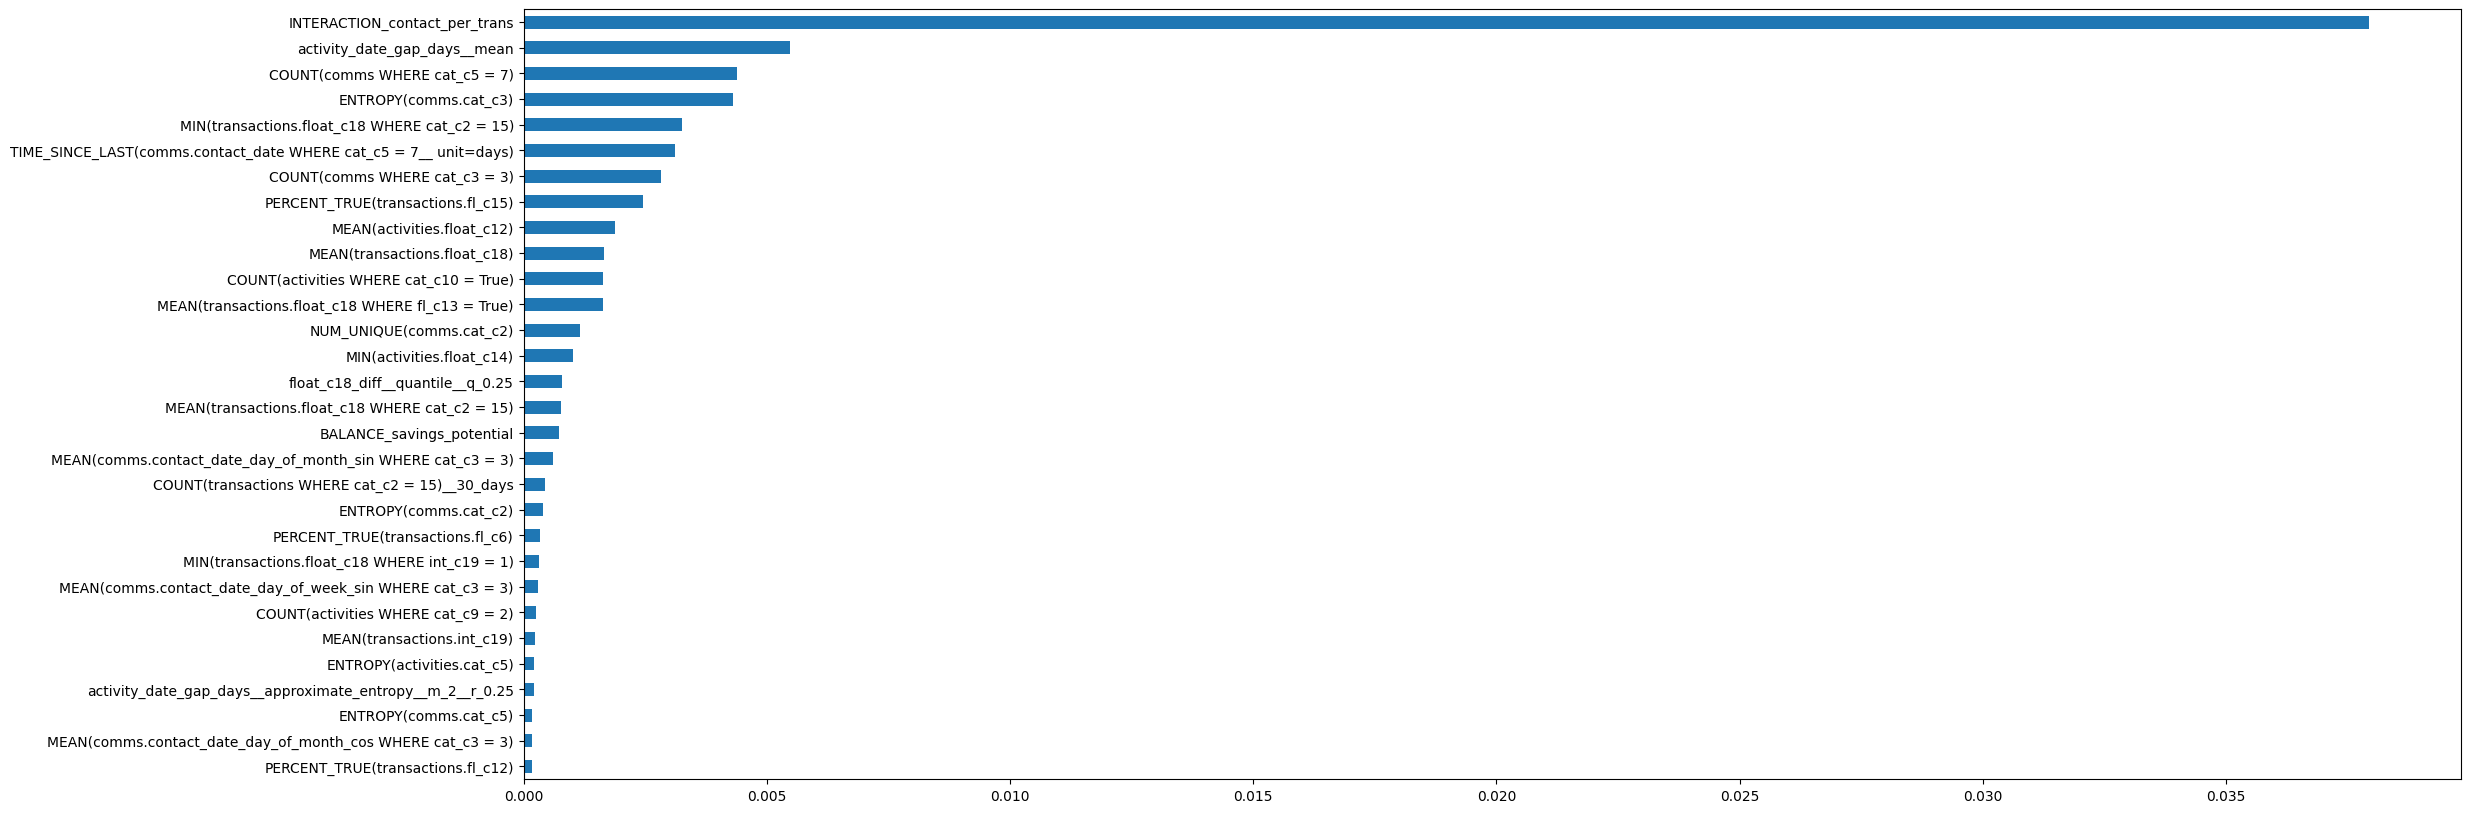

In [106]:
result = permutation_importance(
    model,
    X_valid, y_valid,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc',
    n_jobs=6,
)

features_importance = pd.Series(result.importances_mean, index=X_valid.columns).sort_values(ascending=False)

features_importance.head(30).iloc[::-1].plot(kind='barh', figsize=(25, 10))

plt.show()